Chapter 19

# 两特征贝叶斯分类
Book_5《统计至简》 | 鸢尾花书：从加减乘除到机器学习 (第二版)

这段代码基于鸢尾花数据集，用贝叶斯方法计算鸢尾花不同类别之间两个变量的联合分布，并通过联合、边际和条件独立等视角分析数据。主要步骤如下：

1. **加载数据与初始化**：代码首先加载鸢尾花数据集的两个特征（`X_1`为萼片长度和`X_2`为萼片宽度），并将其用于生成不同类别的概率密度函数 (PDF)。
   
2. **联合概率密度估计**：利用高斯核密度估计器 (KDE) 计算每个类别（C1、C2、C3）的联合概率密度函数 $f_{X_1, X_2|Y}(x_1, x_2|C)$，并用3D图和等高线图进行可视化。对于每个类别，这种联合概率密度被表示为一个三维曲面，描述了`X_1`和`X_2`在该类别下的分布。

3. **边际分布和联合边际可视化**：对于每个类别，还计算并可视化了 $X_1$ 和 $X_2$ 的边际概率密度函数 $f_{X_1|Y}(x_1|C)$ 和 $f_{X_2|Y}(x_2|C)$。这种联合与边际视图可以帮助分析两个变量的分布和其在不同类别下的行为差异。

4. **贝叶斯更新：后验概率计算**：结合各类别的先验概率 $P(Y = C)$ 和联合分布，代码计算了每个类别的后验概率分布 $f_{Y|X_1, X_2}(C|x_1, x_2)$。贝叶斯公式应用如下：
   $$
   f_{Y|X_1, X_2}(C|x_1, x_2) = \frac{f_{X_1, X_2|Y}(x_1, x_2|C) \cdot P(Y = C)}{f_{X_1, X_2}(x_1, x_2)}
   $$
   其中 $f_{X_1, X_2}(x_1, x_2)$ 是证据分布，用于归一化概率。

5. **条件独立性假设下的计算**：假设 $X_1$ 和 $X_2$ 条件独立（即 $f_{X_1, X_2|Y}(x_1, x_2|C) = f_{X_1|Y}(x_1|C) \cdot f_{X_2|Y}(x_2|C)$），代码重新计算联合分布并与条件独立性假设下的联合边际进行对比。

6. **多种可视化**：通过3D投影、等高线图、联合分布图和边际分布图展示每个类别的联合分布、后验分布和条件独立分布。

## 导入必要的库

In [1]:
import numpy as np  # 导入NumPy用于数值计算
import statsmodels.api as sm  # 导入statsmodels用于统计建模
import matplotlib.pyplot as plt  # 导入matplotlib用于绘图
import pandas as pd  # 导入Pandas用于数据处理
from sklearn.datasets import load_iris  # 从sklearn导入Iris数据集
import scipy.stats as st  # 导入SciPy的stats模块用于统计计算

## 定义绘制三维和二维图像的函数

In [2]:
# 定义函数 plot_surface，用于绘制概率分布的3D曲面和2D轮廓
def plot_surface(xx1, xx2, surface, z_height, title_txt):
    fig = plt.figure(figsize=plt.figaspect(0.5))  # 设置图形大小，比例为0.5
    ax = fig.add_subplot(1, 2, 1, projection='3d')  # 创建3D子图，用于显示表面

    ax.plot_wireframe(xx1, xx2, surface, color=[0.7, 0.7, 0.7], linewidth=0.25)  # 绘制网格线框图
    ax.contour3D(xx1, xx2, surface, 20, cmap='RdYlBu_r')  # 绘制3D轮廓图，20层

    ax.set_proj_type('ortho')  # 设置正交投影
    ax.set_xlabel(r'Sepal length, $x_1$')  # 设置x轴标签
    ax.set_ylabel(r'Sepal width, $x_2$')  # 设置y轴标签
    ax.set_zlabel('PDF')  # 设置z轴标签

    # ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # 设置x轴面颜色
    # ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # 设置y轴面颜色
    # ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # 设置z轴面颜色

    ax.set_xticks([4, 5, 6, 7, 8])  # 设置x轴刻度
    ax.set_yticks([1, 2, 3, 4, 5])  # 设置y轴刻度
    ax.set_xlim(x1.min(), x1.max())  # 设置x轴范围
    ax.set_ylim(x2.min(), x2.max())  # 设置y轴范围
    ax.set_zlim3d([0, z_height])  # 设置z轴范围
    ax.view_init(azim=-120, elev=30)  # 设置视角
    ax.set_title(title_txt)  # 设置标题
    ax.grid(False)  # 关闭网格


    ax = fig.add_subplot(1, 2, 2)  # 添加2D子图
    cset = ax.contour(xx1, xx2, surface, 20, cmap='RdYlBu_r')  # 绘制2D轮廓图

    ax.set_xticks([4, 5, 6, 7, 8])  # 设置x轴刻度
    ax.set_yticks([1, 2, 3, 4, 5])  # 设置y轴刻度
    ax.set_xlim(x1.min(), x1.max())  # 设置x轴范围
    ax.set_ylim(x2.min(), x2.max())  # 设置y轴范围

    ax.set_xlabel(r'Sepal length, $x_1$')  # 设置x轴标签
    ax.set_ylabel(r'Sepal width, $x_2$')  # 设置y轴标签
    plt.gca().set_aspect('equal', adjustable='box')  # 设置图形比例
    ax.set_title(title_txt)  # 设置标题


## 定义绘制二维PDF轮廓和边缘分布的函数

In [3]:
import matplotlib.gridspec as gridspec  # 导入gridspec用于网格布局

# 定义函数 plot_joint_marginal，用于绘制二维PDF和边缘分布图
def plot_joint_marginal(xx1, xx2, surface, x1, f_x1, x2, f_x2, x1_s, x2_s, color, title_txt):
    fig = plt.figure(figsize=(7, 7))  # 设置图形大小
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])  # 设置网格布局

    ax1 = plt.subplot(gs[0])  # 添加左上子图，用于绘制联合分布
    ax1.contour(xx1, xx2, surface, 20, cmap='RdYlBu_r')  # 绘制轮廓图
    ax1.scatter(x1_s, x2_s, c=color)  # 绘制散点图

    ax1.set_xlabel(r'Sepal length, $x_1$')  # 设置x轴标签
    ax1.set_ylabel(r'Sepal width, $x_2$')  # 设置y轴标签
    ax1.yaxis.set_label_position('right')  # 设置y轴标签位置
    ax1.set_xticks([])  # 去除x轴刻度
    ax1.set_yticks([])  # 去除y轴刻度
    ax1.set_title(title_txt)  # 设置标题

    ax2 = plt.subplot(gs[1])  # 添加右上子图，用于绘制Y边缘分布
    ax2.plot(f_x2, x2, color=color)  # 绘制Y边缘分布
    ax2.fill_between(f_x2, x2, edgecolor='none', facecolor=color, alpha=0.2)  # 填充Y边缘分布

    ax2.set_xlabel('PDF')  # 设置x轴标签
    ax2.set_ylim(1, 5)  # 设置y轴范围
    ax2.set_xlim(0, 1.5)  # 设置x轴范围
    ax2.set_xticks([0, 0.5, 1, 1.5])  # 设置x轴刻度
    ax2.set_yticks([1, 2, 3, 4, 5])  # 设置y轴刻度
    ax2.invert_xaxis()  # 翻转x轴
    ax2.yaxis.tick_right()  # 设置y轴刻度在右侧

    ax3 = plt.subplot(gs[2])  # 添加左下子图，用于绘制X边缘分布
    ax3.plot(x1, f_x1, color=color)  # 绘制X边缘分布
    ax3.fill_between(x1, f_x1, edgecolor='none', facecolor=color, alpha=0.2)  # 填充X边缘分布

    ax3.set_ylabel('PDF')  # 设置y轴标签
    ax3.yaxis.set_label_position('left')  # 设置y轴标签位置
    ax3.set_xlim(4, 8)  # 设置x轴范围
    ax3.set_xticks([4, 5, 6, 7, 8])  # 设置x轴刻度
    ax3.set_ylim(0, 1.5)  # 设置y轴范围
    ax3.set_yticks([0, 0.5, 1, 1.5])  # 设置y轴刻度

    ax4 = plt.subplot(gs[3])  # 添加右下空白子图
    ax4.set_visible(False)  # 隐藏子图
    plt.show()  # 显示图形

## 数据初始化

In [4]:
iris = load_iris()  # 加载Iris数据集
X_1_to_4 = iris.data  # 获取特征数据
y = iris.target  # 获取标签数据

feature_names = ['Sepal length, $X_1$', 
                 'Sepal width, $X_2$', 
                 'Petal length, $X_3$', 
                 'Petal width, $X_4$']  # 定义特征名称

X_df = pd.DataFrame(X_1_to_4, columns=feature_names)  # 创建包含特征数据的DataFrame
y_df = pd.DataFrame(y, columns=['label'])  # 创建包含标签数据的DataFrame

y_df[y_df == 0] = 'C_1'  # 将标签0替换为'C_1'
y_df[y_df == 1] = 'C_2'  # 将标签1替换为'C_2'
y_df[y_df == 2] = 'C_3'  # 将标签2替换为'C_3'

X1_2_df = X_df[['Sepal length, $X_1$', 'Sepal width, $X_2$']]  # 提取前两个特征的DataFrame

x1 = np.linspace(4, 8, 161)  # 生成x1的线性空间
x2 = np.linspace(1, 5, 161)  # 生成x2的线性空间

xx1, xx2 = np.meshgrid(x1, x2)  # 生成网格数据
positions = np.vstack([xx1.ravel(), xx2.ravel()])  # 将网格数据堆叠为二维数组

C:\Users\james\AppData\Local\Temp\ipykernel_9732\1142963349.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C_1' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  y_df[y_df == 0] = 'C_1'  # 将标签0替换为'C_1'


## 类别C1的似然函数

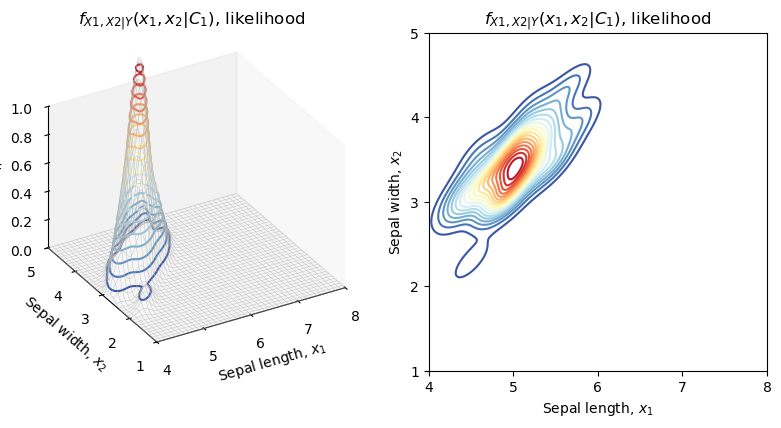

In [5]:
kernel = st.gaussian_kde(X1_2_df[y == 0].values.T)  # 创建类别C1的二维核密度估计
f_x1_x2_given_C1 = np.reshape(kernel(positions).T, xx1.shape)  # 计算二维核密度并重塑为网格形状

z_height = 1  # 设置z轴高度
title_txt = '$f_{X1, X2|Y}(x_1, x_2|C_1)$, likelihood'  # 设置标题
plot_surface(xx1, xx2, f_x1_x2_given_C1, z_height, title_txt)  # 绘制类别C1的联合分布

## 计算类别C1的边缘分布

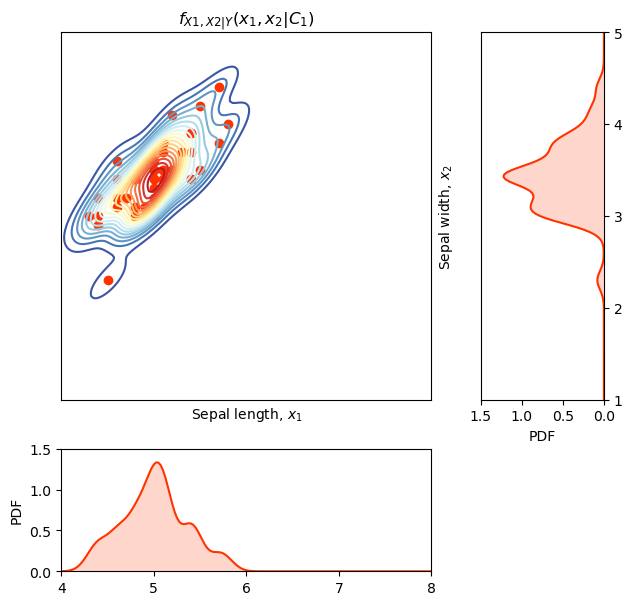

In [6]:
x1_s_C1 = X1_2_df['Sepal length, $X_1$'][y == 0]  # 获取类别C1的x1数据
KDE_x1_given_C1 = sm.nonparametric.KDEUnivariate(x1_s_C1)  # 创建x1的核密度估计
KDE_x1_given_C1.fit(bw=0.1)  # 设置带宽并拟合数据
f_x1_given_C1 = KDE_x1_given_C1.evaluate(x1)  # 评估x1的核密度

x2_s_C1 = X1_2_df['Sepal width, $X_2$'][y == 0]  # 获取类别C1的x2数据
KDE_x2_given_C1 = sm.nonparametric.KDEUnivariate(x2_s_C1)  # 创建x2的核密度估计
KDE_x2_given_C1.fit(bw=0.1)  # 设置带宽并拟合数据
f_x2_given_C1 = KDE_x2_given_C1.evaluate(x2)  # 评估x2的核密度

title_txt = '$f_{X1,X2|Y}(x_1,x_2|C_1)$'  # 设置标题
plot_joint_marginal(xx1, xx2, f_x1_x2_given_C1, x1, f_x1_given_C1, x2, f_x2_given_C1, x1_s_C1, x2_s_C1, '#FF3300', title_txt)  # 绘制联合和边缘分布

## 类别C2的似然函数

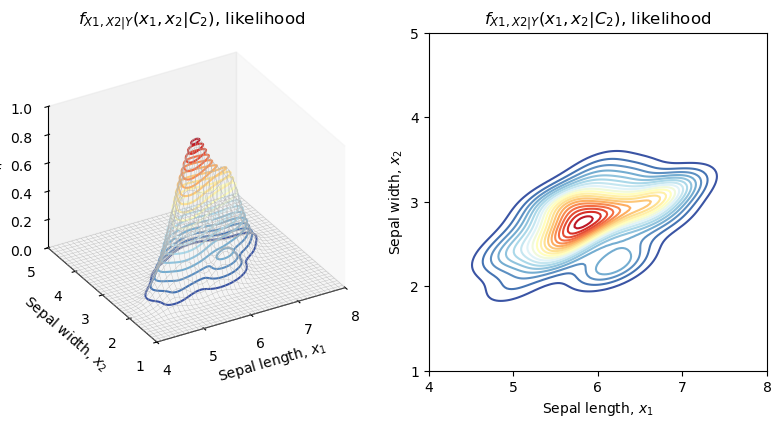

In [7]:
kernel = st.gaussian_kde(X1_2_df[y == 1].values.T)  # 创建类别C2的二维核密度估计
f_x1_x2_given_C2 = np.reshape(kernel(positions).T, xx1.shape)  # 计算二维核密度并重塑为网格形状

z_height = 1  # 设置z轴高度
title_txt = '$f_{X1, X2|Y}(x_1, x_2|C_2)$, likelihood'  # 设置标题
plot_surface(xx1, xx2, f_x1_x2_given_C2, z_height, title_txt)  # 绘制类别C2的联合分布

In [8]:
# 计算类别C2的边缘分布

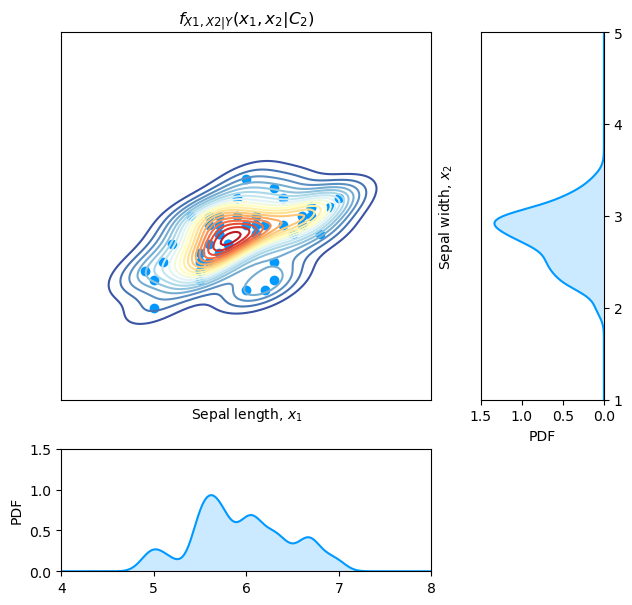

In [9]:
x1_s_C2 = X1_2_df['Sepal length, $X_1$'][y == 1]  # 获取类别C2的x1数据
KDE_x1_given_C2 = sm.nonparametric.KDEUnivariate(x1_s_C2)  # 创建x1的核密度估计
KDE_x1_given_C2.fit(bw=0.1)  # 设置带宽并拟合数据
f_x1_given_C2 = KDE_x1_given_C2.evaluate(x1)  # 评估x1的核密度

x2_s_C2 = X1_2_df['Sepal width, $X_2$'][y == 1]  # 获取类别C2的x2数据
KDE_x2_given_C2 = sm.nonparametric.KDEUnivariate(x2_s_C2)  # 创建x2的核密度估计
KDE_x2_given_C2.fit(bw=0.1)  # 设置带宽并拟合数据
f_x2_given_C2 = KDE_x2_given_C2.evaluate(x2)  # 评估x2的核密度

title_txt = '$f_{X1,X2|Y}(x_1,x_2|C_2)$'  # 设置标题
plot_joint_marginal(xx1, xx2, f_x1_x2_given_C2, x1, f_x1_given_C2, x2, f_x2_given_C2, x1_s_C2, x2_s_C2, '#0099FF', title_txt)  # 绘制联合和边缘分布

In [10]:
## 类别C3的似然函数

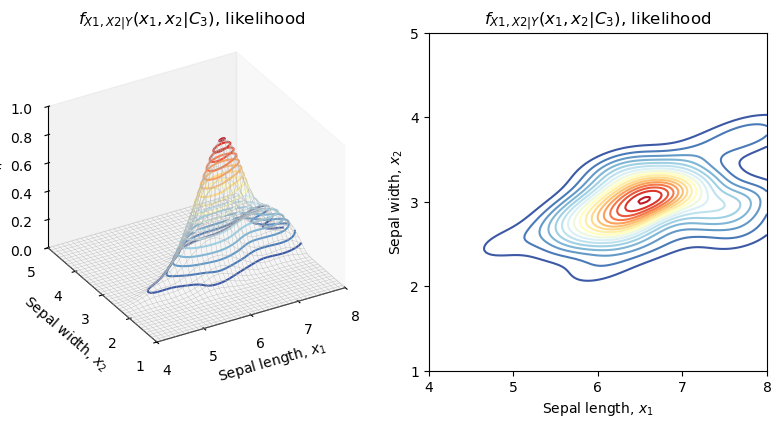

In [11]:
kernel = st.gaussian_kde(X1_2_df[y == 2].values.T)  # 创建类别C3的二维核密度估计
f_x1_x2_given_C3 = np.reshape(kernel(positions).T, xx1.shape)  # 计算二维核密度并重塑为网格形状

z_height = 1  # 设置z轴高度
title_txt = '$f_{X1, X2|Y}(x_1, x_2|C_3)$, likelihood'  # 设置标题
plot_surface(xx1, xx2, f_x1_x2_given_C3, z_height, title_txt)  # 绘制类别C3的联合分布

## 计算类别C3的边缘分布

In [12]:
x1_s_C3 = X1_2_df['Sepal length, $X_1$'][y == 2]  # 获取类别C3的x1数据
KDE_x1_given_C3 = sm.nonparametric.KDEUnivariate(x1_s_C3)  # 创建x1的核密度估计
KDE_x1_given_C3.fit(bw=0.1)  # 设置带宽并拟合数据
f_x1_given_C3 = KDE_x1_given_C3.evaluate(x1)  # 评估x1的核密度

In [13]:
x2_s_C3 = X1_2_df['Sepal width, $X_2$'][y == 2]  # 获取类别C3的x2数据
KDE_x2_given_C3 = sm.nonparametric.KDEUnivariate(x2_s_C3)  # 创建x2的核密度估计
KDE_x2_given_C3.fit(bw=0.1)  # 设置带宽并拟合数据
f_x2_given_C3 = KDE_x2_given_C3.evaluate(x2)  # 评估x2的核密度

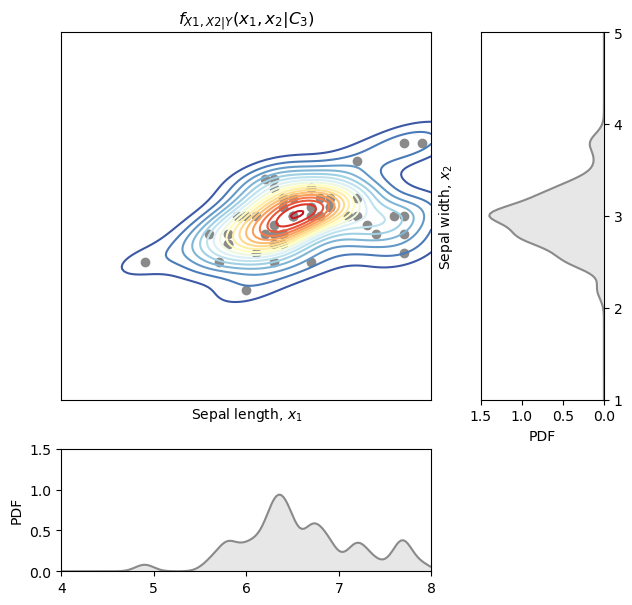

In [14]:
title_txt = '$f_{X1,X2|Y}(x_1,x_2|C_3)$'  # 设置标题
plot_joint_marginal(xx1, xx2, f_x1_x2_given_C3, x1, f_x1_given_C3, x2, f_x2_given_C3, x1_s_C3, x2_s_C3, '#8A8A8A', title_txt)  # 绘制联合和边缘分布

## 计算每个类别的先验概率（Prior probability）

In [15]:
y_counts = y_df.value_counts()  # 统计每个类别的样本数量

# 定义颜色
my_colors = ['#FF3300', '#0099FF', '#8A8A8A']

Text(0, 0.5, 'Count')

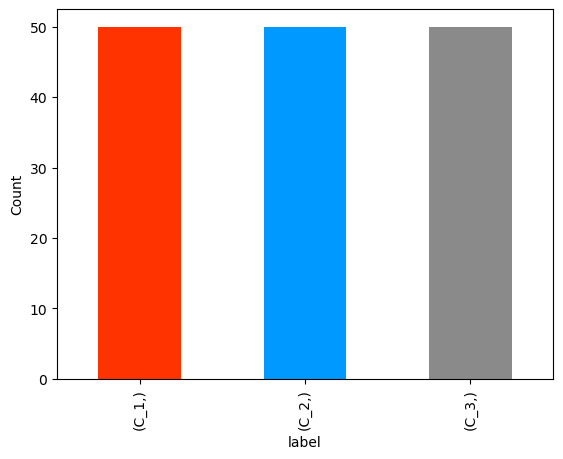

In [16]:
fig, ax = plt.subplots()  # 创建图表

y_counts.plot.bar(color=my_colors)  # 绘制条形图，显示每个类别的样本数量
y_prob = y_counts / y_df.count().values[0]  # 计算每个类别的先验概率
plt.ylabel('Count')  # 设置y轴标签

Text(0, 0.5, 'Prior probability')

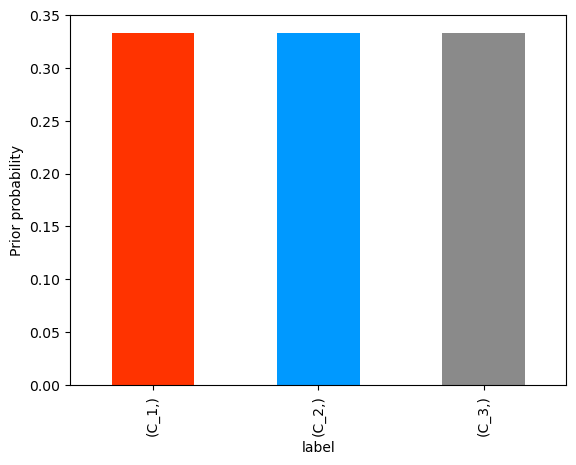

In [17]:
fig, ax = plt.subplots()  # 创建新图表

y_prob.plot.bar(color=my_colors)  # 绘制条形图，显示每个类别的先验概率
plt.ylabel('Prior probability')  # 设置y轴标签

## 计算联合概率密度函数（Joint PDF）

In [18]:
f_x1_x2_joint_C1 = f_x1_x2_given_C1 * y_prob['C_1']  # 计算类别C1的联合概率密度
f_x1_x2_joint_C2 = f_x1_x2_given_C2 * y_prob['C_2']  # 计算类别C2的联合概率密度
f_x1_x2_joint_C3 = f_x1_x2_given_C3 * y_prob['C_3']  # 计算类别C3的联合概率密度

## 绘制类别C1的联合分布

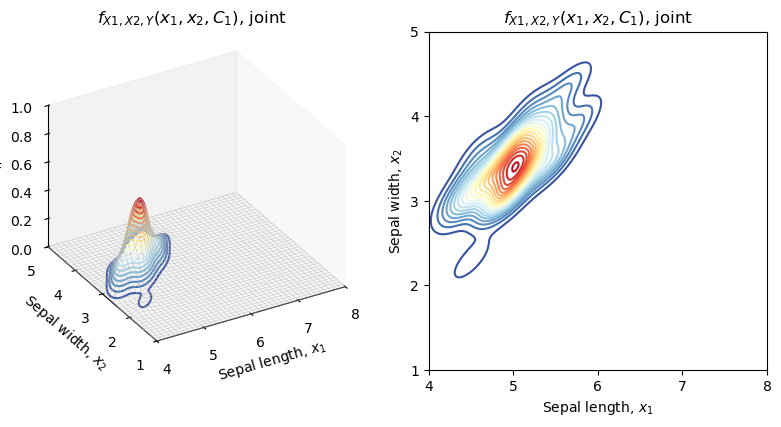

In [19]:
z_height = 1  # 设置z轴高度
title_txt = '$f_{X1, X2, Y}(x_1, x_2, C_1)$, joint'  # 设置标题
plot_surface(xx1, xx2, f_x1_x2_joint_C1, z_height, title_txt)  # 调用函数绘制图形

## 绘制类别C2的联合分布

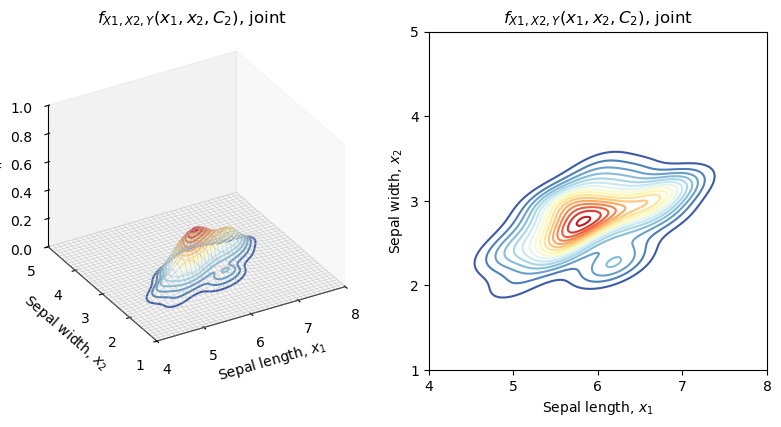

In [20]:
title_txt = '$f_{X1, X2, Y}(x_1, x_2, C_2)$, joint'
plot_surface(xx1, xx2, f_x1_x2_joint_C2, z_height, title_txt)

## 绘制类别C3的联合分布

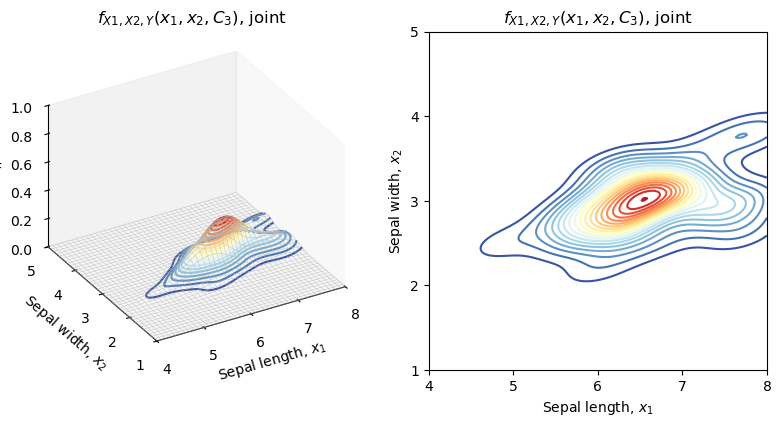

In [21]:
title_txt = '$f_{X1, X2, Y}(x_1, x_2, C_3)$, joint'
plot_surface(xx1, xx2, f_x1_x2_joint_C3, z_height, title_txt)

## 计算边缘证据（Evidence） fX_1, X_2(x_1, x_2)

In [22]:
f_x1_x2 = f_x1_x2_joint_C1 + f_x1_x2_joint_C2 + f_x1_x2_joint_C3  # 计算所有类别的边缘联合概率密度

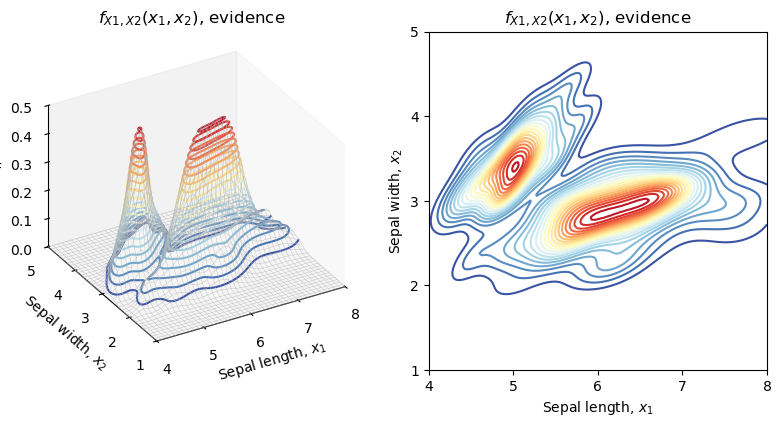

In [23]:
z_height = 0.5  # 设置z轴高度
title_txt = '$f_{X1, X2}(x_1, x_2)$, evidence'  # 设置标题
plot_surface(xx1, xx2, f_x1_x2, z_height, title_txt)  # 绘制边缘联合分布

## 计算后验概率（Posterior）

In [24]:
f_C1_given_x1_x2 = f_x1_x2_joint_C1 / f_x1_x2  # 计算类别C1的后验概率
f_C2_given_x1_x2 = f_x1_x2_joint_C2 / f_x1_x2  # 计算类别C2的后验概率
f_C3_given_x1_x2 = f_x1_x2_joint_C3 / f_x1_x2  # 计算类别C3的后验概率

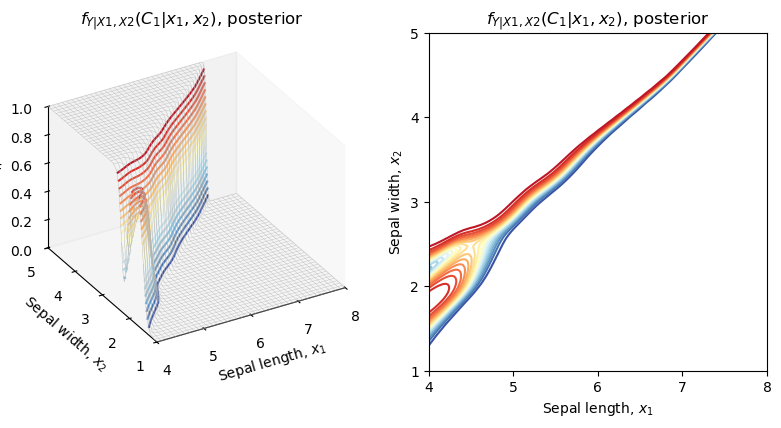

In [25]:
# 绘制类别C1的后验分布
z_height = 1  # 设置z轴高度
title_txt = '$f_{Y|X1, X2}(C_1|x_1, x_2)$, posterior'  # 设置标题
plot_surface(xx1, xx2, f_C1_given_x1_x2, z_height, title_txt)

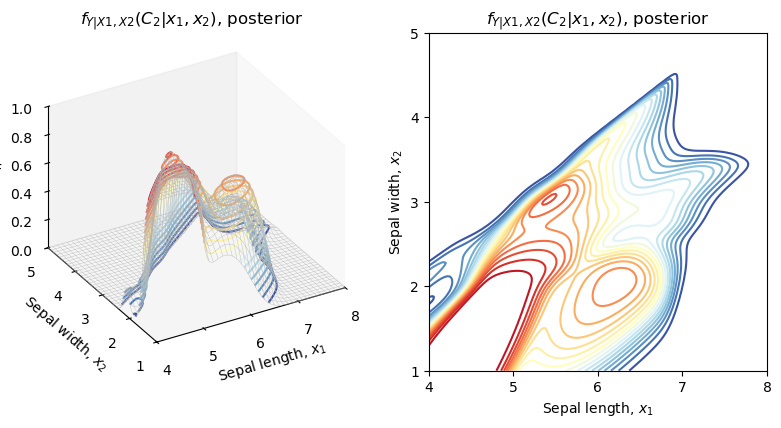

In [26]:
# 绘制类别C2的后验分布
title_txt = '$f_{Y|X1, X2}(C_2|x_1, x_2)$, posterior'
plot_surface(xx1, xx2, f_C2_given_x1_x2, z_height, title_txt)

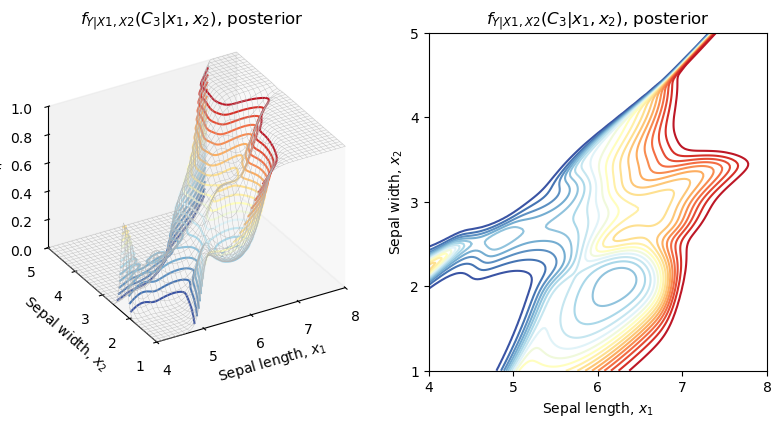

In [27]:
# 绘制类别C3的后验分布
title_txt = '$f_{Y|X1, X2}(C_3|x_1, x_2)$, posterior'
plot_surface(xx1, xx2, f_C3_given_x1_x2, z_height, title_txt)

## 计算独立性证据（evidence, independence）

In [28]:
x1_s = X1_2_df['Sepal length, $X_1$']  # 获取花萼长度数据

KDE_X1 = sm.nonparametric.KDEUnivariate(x1_s)  # 创建核密度估计对象
KDE_X1.fit(bw=0.1)  # 设置带宽并拟合数据

In [29]:
f_x1 = KDE_X1.evaluate(x1)  # 评估x1的核密度

In [30]:
x2_s = X1_2_df['Sepal width, $X_2$']  # 获取花萼宽度数据

In [31]:
KDE_X2 = sm.nonparametric.KDEUnivariate(x2_s)  # 创建核密度估计对象
KDE_X2.fit(bw=0.1)  # 设置带宽并拟合数据

In [32]:
f_x2 = KDE_X2.evaluate(x2)  # 评估x2的核密度

In [33]:
f_x1_x2_indp = np.outer(f_x2, f_x1)  # 计算x1和x2的外积，用于独立性假设下的联合密度

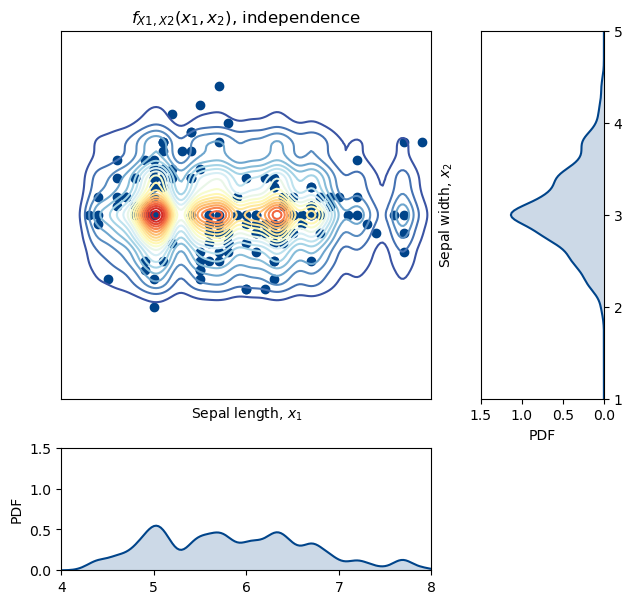

In [34]:
title_txt = '$f_{X1,X2}(x_1,x_2)$, independence'  # 设置标题
plot_joint_marginal(xx1, xx2, f_x1_x2_indp, x1, f_x1, x2, f_x2, x1_s, x2_s, '#00448A', title_txt)  # 绘制联合和边缘分布图

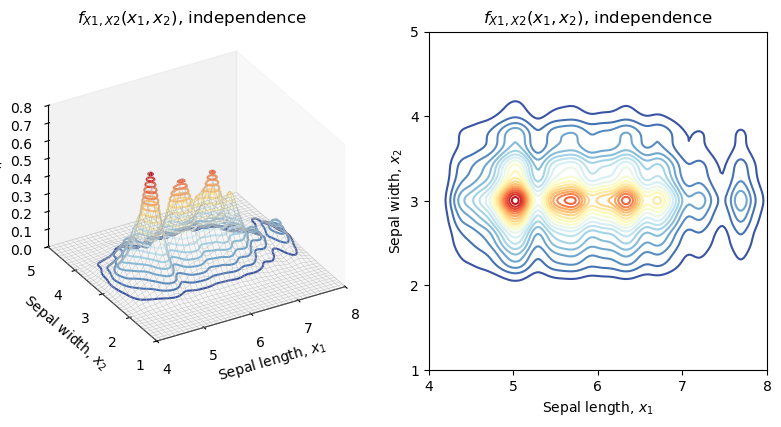

In [35]:
z_height = 0.8  # 设置z轴高度
title_txt = '$f_{X1, X2}(x_1, x_2)$, independence'  # 设置标题
plot_surface(xx1, xx2, f_x1_x2_indp, z_height, title_txt)  # 绘制独立性假设下的联合分布

## 将独立性证据投影到Y轴到X-Z平面

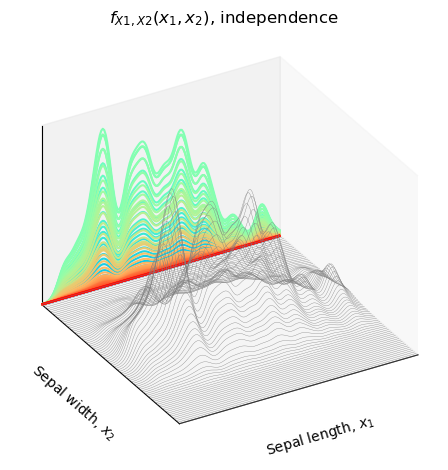

In [36]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})  # 创建3D子图

ax.plot_wireframe(xx1, xx2, f_x1_x2_indp, rstride=2, cstride=0, color=[0.5, 0.5, 0.5], linewidth=0.25)  # 绘制3D网格线
ax.contour(xx1, xx2, f_x1_x2_indp, levels=80, zdir='y', offset=xx2.max(), cmap='rainbow')  # 绘制2D轮廓图

ax.set_xlabel('Sepal length, $x_1$')  # 设置x轴标签
ax.set_ylabel('Sepal width, $x_2$')  # 设置y轴标签
ax.set_title(title_txt)  # 设置标题
ax.set_proj_type('ortho')  # 设置正交投影
ax.set_xticks([])  # 去除x轴刻度
ax.set_yticks([])  # 去除y轴刻度
ax.set_zticks([])  # 去除z轴刻度
ax.view_init(azim=-120, elev=30)  # 设置视角
ax.grid(False)  # 关闭网格
ax.set_xlim(4, 8)  # 设置x轴范围
ax.set_ylim(1, 5)  # 设置y轴范围
ax.set_zlim(0, 0.7)  # 设置z轴范围
plt.tight_layout()  # 调整布局
ax.view_init(azim=-120, elev=30)  # 设置视角
plt.show()  # 显示图形

## 将独立性证据投影到X轴到Y-Z平面

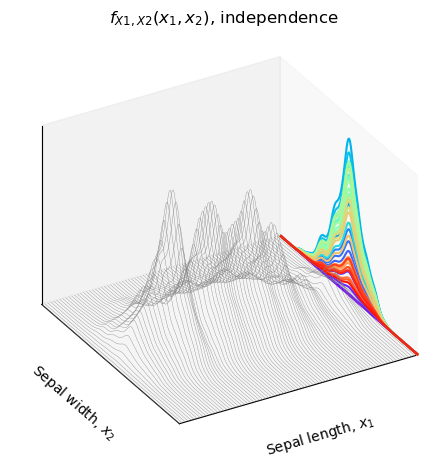

In [37]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})  # 创建3D子图

ax.plot_wireframe(xx1, xx2, f_x1_x2_indp, rstride=0, cstride=2, color=[0.5, 0.5, 0.5], linewidth=0.25)  # 绘制3D网格线
ax.contour(xx1, xx2, f_x1_x2_indp, levels=40, zdir='x', offset=xx1.max(), cmap='rainbow')  # 绘制2D轮廓图

ax.set_xlabel('Sepal length, $x_1$')  # 设置x轴标签
ax.set_ylabel('Sepal width, $x_2$')  # 设置y轴标签
ax.set_title(title_txt)  # 设置标题
ax.set_proj_type('ortho')  # 设置正交投影
ax.set_xticks([])  # 去除x轴刻度
ax.set_yticks([])  # 去除y轴刻度
ax.set_zticks([])  # 去除z轴刻度
ax.view_init(azim=-120, elev=30)  # 设置视角
ax.grid(False)  # 关闭网格
ax.set_xlim(4, 8)  # 设置x轴范围
ax.set_ylim(1, 5)  # 设置y轴范围
ax.set_zlim(0, 0.7)  # 设置z轴范围
plt.tight_layout()  # 调整布局
ax.view_init(azim=-120, elev=30)  # 设置视角
plt.show()  # 显示图形

## 条件独立

## C1, 条件独立

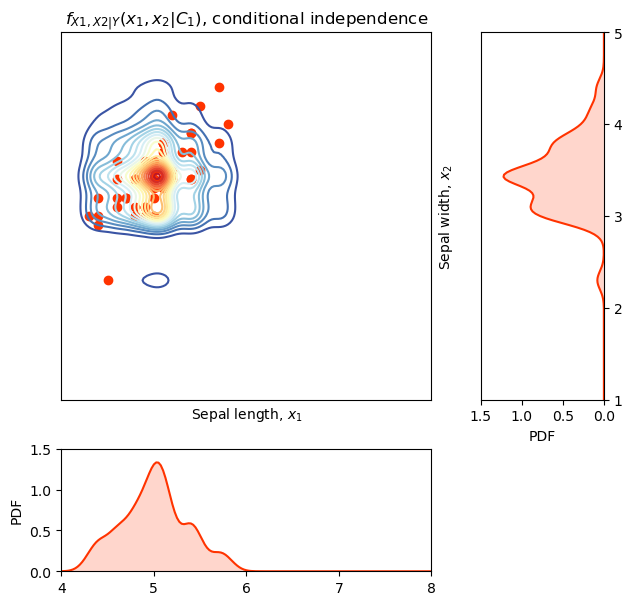

In [38]:
f_x1_x2_condi_indp_given_C1 = np.outer(f_x2_given_C1, f_x1_given_C1)  # 计算条件独立假设下 C1 的联合概率密度

title_txt = '$f_{X1,X2|Y}(x_1,x_2|C_1)$, conditional independence'  # 设置标题
plot_joint_marginal(xx1, xx2, f_x1_x2_condi_indp_given_C1,  # 绘制联合概率和边际分布
                    x1, f_x1_given_C1,
                    x2, f_x2_given_C1,
                    x1_s_C1, x2_s_C1,
                    '#FF3300', title_txt)

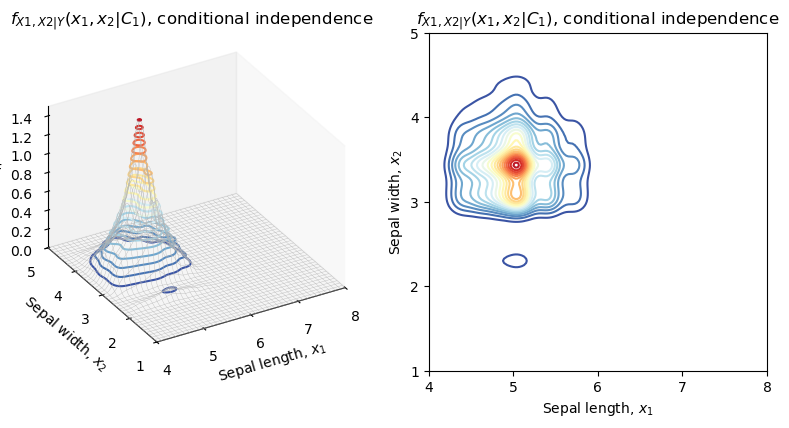

In [39]:
z_height = 1.5  # 设置图表高度
title_txt = '$f_{X1, X2|Y}(x_1, x_2|C_1)$, conditional independence'  # 更新标题
plot_surface(xx1, xx2, f_x1_x2_condi_indp_given_C1, z_height, title_txt)  # 绘制 3D 表面图

## C2, 条件独立

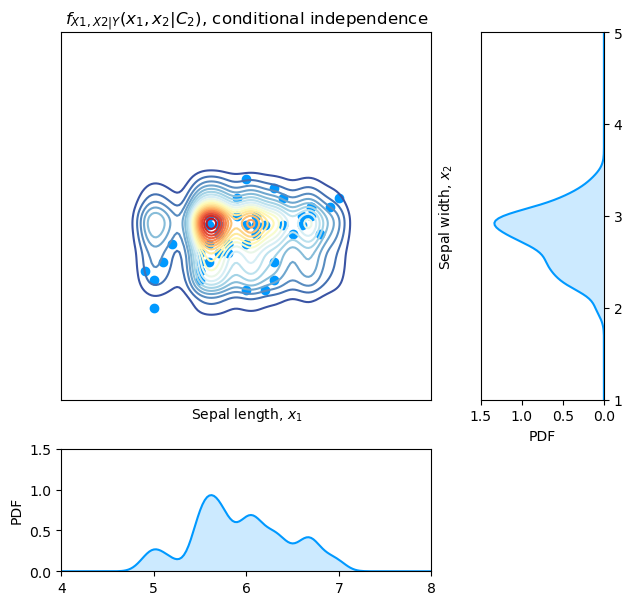

In [40]:
f_x1_x2_condi_indp_given_C2 = np.outer(f_x2_given_C2, f_x1_given_C2)  # 计算条件独立假设下 C2 的联合概率密度

title_txt = '$f_{X1,X2|Y}(x_1,x_2|C_2)$, conditional independence'  # 设置标题
plot_joint_marginal(xx1, xx2, f_x1_x2_condi_indp_given_C2,  # 绘制联合概率和边际分布
                    x1, f_x1_given_C2,
                    x2, f_x2_given_C2,
                    x1_s_C2, x2_s_C2,
                    '#0099FF', title_txt)

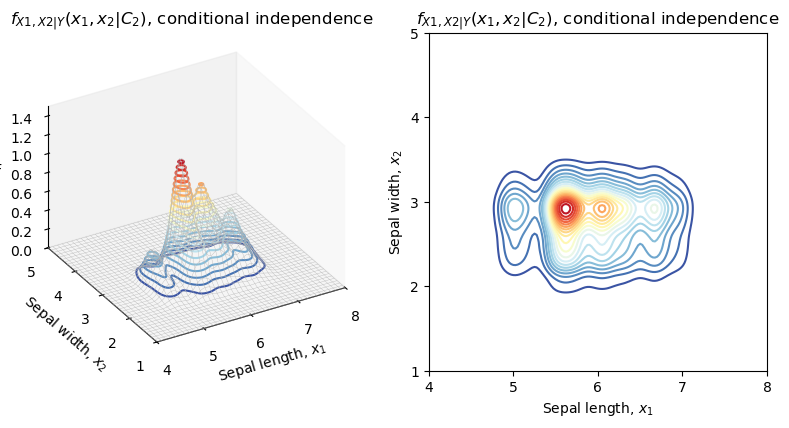

In [41]:
z_height = 1.5  # 设置图表高度
title_txt = '$f_{X1, X2|Y}(x_1, x_2|C_2)$, conditional independence'  # 更新标题
plot_surface(xx1, xx2, f_x1_x2_condi_indp_given_C2, z_height, title_txt)  # 绘制 3D 表面图

## C3, 条件独立

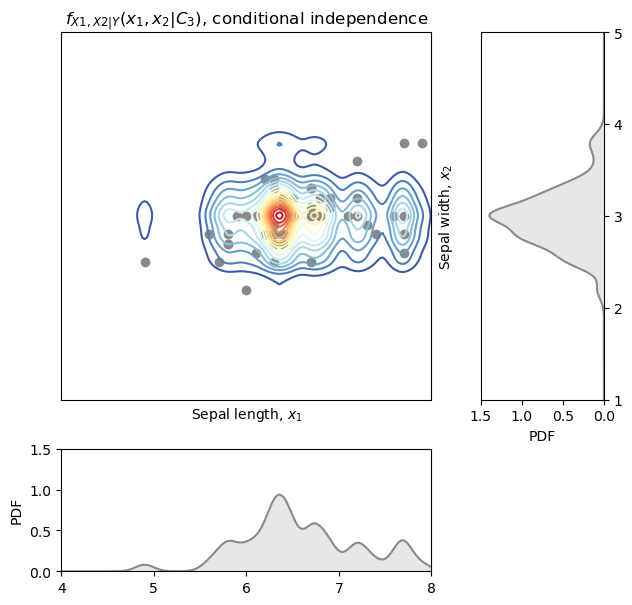

In [42]:
f_x1_x2_condi_indp_given_C3 = np.outer(f_x2_given_C3, f_x1_given_C3)  # 计算条件独立假设下 C3 的联合概率密度

title_txt = '$f_{X1,X2|Y}(x_1,x_2|C_3)$, conditional independence'  # 设置标题
plot_joint_marginal(xx1, xx2, f_x1_x2_condi_indp_given_C3,  # 绘制联合概率和边际分布
                    x1, f_x1_given_C3,
                    x2, f_x2_given_C3,
                    x1_s_C3, x2_s_C3,
                    '#8A8A8A', title_txt)

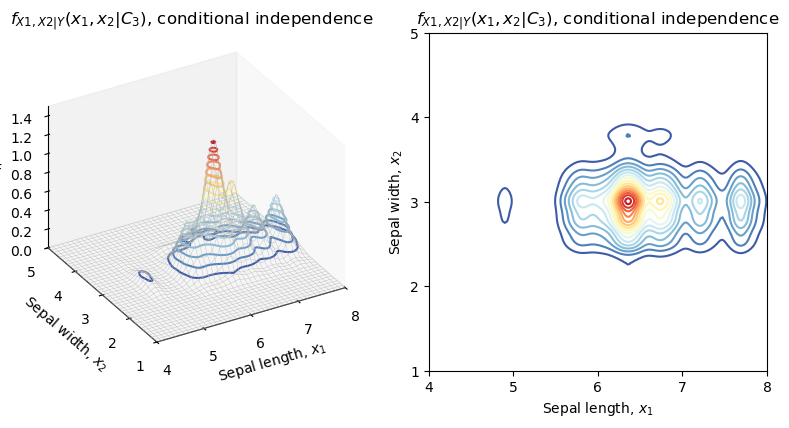

In [43]:
z_height = 1.5  # 设置图表高度
title_txt = '$f_{X1, X2|Y}(x_1, x_2|C_3)$, conditional independence'  # 更新标题
plot_surface(xx1, xx2, f_x1_x2_condi_indp_given_C3, z_height, title_txt)  # 绘制 3D 表面图

## 证据因子 fX_1, X_2(x_1, x_2), 条件独立

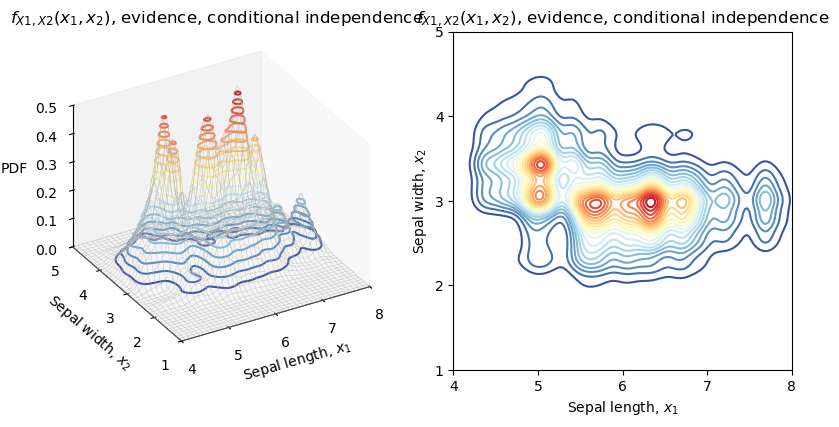

In [44]:
f_x1_x2_condi_indp = (f_x1_x2_condi_indp_given_C1 * y_prob['C_1'] + 
                      f_x1_x2_condi_indp_given_C2 * y_prob['C_2'] + 
                      f_x1_x2_condi_indp_given_C3 * y_prob['C_3'])  # 结合类概率和条件分布计算总体联合概率

z_height = 0.5  # 设置图表高度
title_txt = '$f_{X1, X2}(x_1, x_2)$, evidence, conditional independence'  # 设置标题
plot_surface(xx1, xx2, f_x1_x2_condi_indp, z_height, title_txt)  # 绘制 3D 表面图

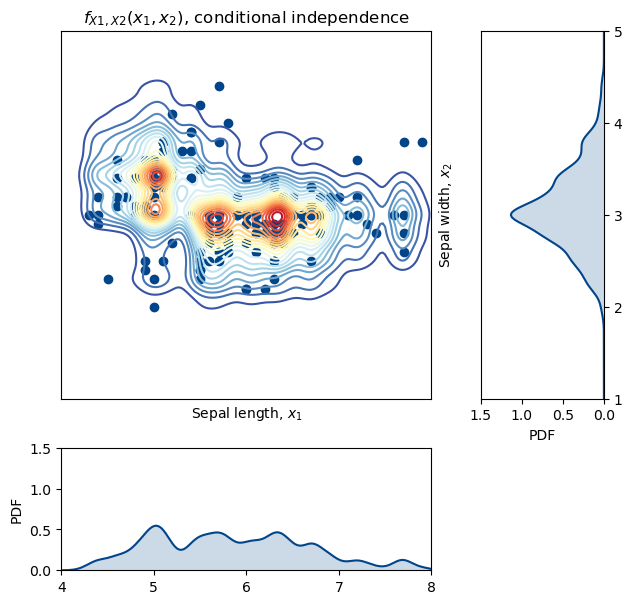

In [45]:
title_txt = '$f_{X1,X2}(x_1,x_2)$, conditional independence'  # 更新标题
plot_joint_marginal(xx1, xx2, f_x1_x2_condi_indp,  # 绘制联合概率和边际分布
                    x1, f_x1,
                    x2, f_x2,
                    x1_s, x2_s,
                    '#00448A', title_txt)

## 投影在X-Z平面

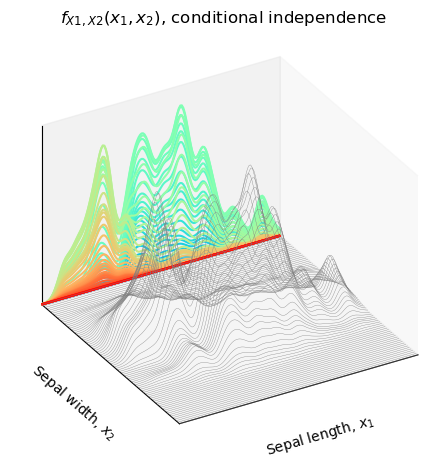

In [46]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})  # 创建一个 3D 绘图对象

ax.plot_wireframe(xx1, xx2, f_x1_x2_condi_indp,  # 绘制联合概率密度的网格线框
                  rstride=2, cstride=0,  # 设置行步长为 2，列步长为 0
                  color=[0.5, 0.5, 0.5],  # 设置网格线颜色为灰色
                  linewidth=0.25)  # 设置网格线宽度为 0.25

ax.contour(xx1, xx2, f_x1_x2_condi_indp,  # 在 X-Z 平面上绘制等高线
           levels=80, zdir='y',  # 等高线数量为 80，沿 y 轴投影
           offset=xx2.max(), cmap='rainbow')  # 设置等高线的偏移量和颜色映射

ax.set_xlabel('Sepal length, $x_1$')  # 设置 x 轴标签
ax.set_ylabel('Sepal width, $x_2$')  # 设置 y 轴标签
ax.set_title(title_txt)  # 设置图表标题
ax.set_proj_type('ortho')  # 设置投影为正交模式
ax.set_xticks([])  # 移除 x 轴刻度
ax.set_yticks([])  # 移除 y 轴刻度
ax.set_zticks([])  # 移除 z 轴刻度
ax.view_init(azim=-120, elev=30)  # 设置观察角度，方位角 -120°，仰角 30°
ax.grid(False)  # 移除网格线
ax.set_xlim(4, 8)  # 设置 x 轴范围
ax.set_ylim(1, 5)  # 设置 y 轴范围
ax.set_zlim(0, 0.7)  # 设置 z 轴范围
plt.tight_layout()  # 调整图形布局
ax.view_init(azim=-120, elev=30)  # 再次设置视角
plt.show()  # 显示图形